In [ ]:
pip install lpips

     |████████████████████████████████| 53 kB 1.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import lpips
import numpy as np
import torch
import matplotlib.pyplot as plt

Construct the model with different Networks. Please refer to this [link](https:/
/pypi.org/project/lpips/).

In [ ]:
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization
loss_fn_squ = lpips.LPIPS(net='squeeze')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/squeeze.pth


Import image data and observer behavier data. Here we are using the random sampled experiment image dataset and its behavior data. The follow codes are used to import data from google drive. You may download the data file on google drive and upload it on the lab.

In [ ]:
left_img=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/left_img_data_random.npy')
right_img=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/right_img_data_random.npy')
target=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/target_data_Eddy_random.npy')

Image examples.

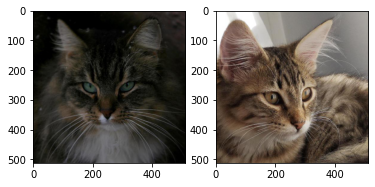

In [ ]:
img_l=left_img[0]
img_r=right_img[0]
plt.subplot(1,2,1)
plt.imshow(img_l)
plt.subplot(1,2,2)
plt.imshow(img_r)
plt.show()

Below I modified the input as author requested before conculating the distance between two images.

In [ ]:
img_l, img_r=np.array([img_l[:,:,0],img_l[:,:,1],img_l[:,:,2]]).reshape(1,3,512,512),np.array([img_r[:,:,0],img_r[:,:,1],img_r[:,:,2]]).reshape(1,3,512,512)# reshape the image matrix
img_l, img_r=(img_l - np.min(img_l)) / (np.max(img_l) - np.min(img_l)),(img_r - np.min(img_r)) / (np.max(img_r) - np.min(img_r)) # normalized image
img1=torch.from_numpy(img_l).float()
img2=torch.from_numpy(img_r).float()
d, ret=loss_fn_vgg(img1,img2,retPerLayer=True, normalize=True)#retPerLayer=True obtain the L2 distance fron each layers, normalize=True normalized the data from [0,1] into [-1,1]

In [ ]:
ret

[tensor([[[[0.1180]]]], grad_fn=<MeanBackward1>),
 tensor([[[[0.1144]]]], grad_fn=<MeanBackward1>),
 tensor([[[[0.1143]]]], grad_fn=<MeanBackward1>),
 tensor([[[[0.1699]]]], grad_fn=<MeanBackward1>),
 tensor([[[[0.1266]]]], grad_fn=<MeanBackward1>)]

Below codes are for computing the pair distance over whole dataset. Since the memory shortage of Google Colab, I firstly store the distance value into google drive every 100 steps. Afterward, I gather the data from google drive with same variable into one piece and store it into google drive as final version.

In [ ]:
step=100
for i in range(0,len(target),step):
  d_vgg=[]
  d_vgg_ret=[]
  for img_l,img_r in zip(left_img[i:i+step],right_img[i:i+step]):
      img_l, img_r=np.array([img_l[:,:,0],img_l[:,:,1],img_l[:,:,2]]).reshape(1,3,512,512),np.array([img_r[:,:,0],img_r[:,:,1],img_r[:,:,2]]).reshape(1,3,512,512)# reshape the image matrix
      img_l, img_r=(img_l - np.min(img_l)) / (np.max(img_l) - np.min(img_l)),(img_r - np.min(img_r)) / (np.max(img_r) - np.min(img_r)) # normalized image
      img1=torch.from_numpy(img_l).float()
      img2=torch.from_numpy(img_r).float()
      d, ret=loss_fn_vgg(img1,img2,retPerLayer=True, normalize=True) 
      #retPerLayer=True means getting each value from the layers of LPIPS, normalize=True means trun input from [0,1] scale into [-1,1] scale
      d_vgg.append(d)
      d_vgg_ret.append(ret)
  np.save(rf'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_{i+step}.npy',d_vgg)
  np.save(rf'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_ret_{i+step}.npy',d_vgg_ret)

In [ ]:
step=100
d_vgg=[]
d_vgg_ret=[]
for i in range(0,len(target),step):
  for data in np.load(rf'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_{i+step}.npy',allow_pickle=True):
    d_vgg.append(data)
  for data in np.load(rf'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_ret_{i+step}.npy',allow_pickle=True):
    d_vgg_ret.append(data)
d_vgg=np.array(d_vgg)
d_vgg_ret=np.array(d_vgg_ret)


In [ ]:
np.save(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg.npy',d_vgg)
np.save(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_ret.npy',d_vgg_ret)